# Credit Card Fraud

### _Group 5 - LIU Wenzhuo, SUN Wang, ZHANG Bolong, ZHANG Shangyuan_

---

## Table of contents

### [1. Data exploration](#data-exploration)
- [1.1 Get data](#1.1get-data)
- [1.2 Class distribution](#1.2class-distribution)
- [1.3 Feature distribution](#1.3feature-distribution)
- [1.4 Correlation matrix](#1.4correlation-matrix)
- [1.5 T-SNE for undersampling data](#1.5t-sne-for-undersampling-data)

### [2. Machine learning](#machine-learning)
- [2.1 Feature engineering](#2.1feature-engineering)
- [2.2 Supervised learning - Baseline](#2.2supervised-learning-baseline)
    - [2.2.1 Undersampling+LR](#2.2.1undersampling-lr)
- [2.3 Unsupervised learning](#2.3unsupervised-learning)
    - [2.3.1 Local Outlier Factor](#2.3.1local-outlier-factor)
    - [2.3.2 One-Class SVM](#2.3.2one-class-svm)
    - [2.3.3 Isolation Forest](#2.3.3isolation-forest)
    - [2.3.4 Multivariate Gaussian](#2.3.4multivariate-gaussian)
- [2.4 Semi-supervised learning](#2.4semi-supervised-learning)
    - [2.4.1 Auto-encoder](#2.4.1auto-encoder)
    - [2.4.2 Linear classifier prediction](#2.4.2linear-classifier-prediction)

### [3. Evaluation](#evaluation)
- [3.1 Metric with label](#3.1metric-with-label)
    - [3.1.1 Confusion matrix](#3.1.1confusion-matrix)
    - [3.1.2 F1 score](#3.1.2f1-score)
    - [3.1.3 PR-AUC](#3.1.3pr-auc)
- [3.2 Metric without label](#3.2metric-without-label)
    - [3.2.1 Calinski-Harabaz score](#3.2.1calinski-harabaz-score)
    - [3.2.2 Inovation: new metric without label](#3.2.2bolong-score)
    
---

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from numpy.random import seed
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
seed(42)
%matplotlib inline

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.utils.fixes import signature
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, silhouette_score, calinski_harabaz_score

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Split data to training set and test set

In [2]:
data = pd.read_csv('data/creditcard.csv')
# X = data.drop(['Class'], axis=1)
# y = data['Class']

In [3]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
# X_train.to_csv('data/X_train.csv', index=False)
# X_test.to_csv('data/X_test.csv', index=False)
# y_train.to_csv('data/y_train.csv', index=False)
# y_test.to_csv('data/y_test.csv', index=False)

## 1. Data exploration <a id="data-exploration"></a>
### 1.1 Get data <a id="1.1get-data"></a>

In [5]:
X_train = pd.read_csv("data/X_train.csv")
y_train = pd.read_csv("data/y_train.csv", names=['Class'])
X_test = pd.read_csv("data/X_test.csv")
y_test = pd.read_csv("data/y_test.csv", names=['Class'])

In [6]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,60008.0,1.236016,-0.532254,-1.598697,-2.000970,1.847243,2.866321,-0.403133,0.674711,0.982541,...,0.140849,0.074687,0.067211,-0.252346,1.034092,0.936118,-0.585707,0.037147,0.024835,69.41
1,87730.0,-1.354662,0.132957,-0.071744,-2.143004,3.883435,3.105698,0.333710,0.730099,-0.246574,...,0.015409,-0.412867,-1.043888,-0.421561,0.711301,0.606336,0.241368,-0.003143,-0.170308,0.99
2,9340.0,1.217838,0.430202,0.423582,0.845296,-0.098465,-0.553254,-0.076397,-0.152638,1.294955,...,-0.149407,-0.409539,-0.891155,0.169831,-0.023733,0.124676,0.085188,-0.032357,0.021126,0.99
3,129550.0,2.083280,-0.075132,-1.358963,0.260593,0.227679,-0.800119,0.226624,-0.325823,0.503781,...,-0.137106,-0.319557,-0.788921,0.235359,-0.638908,-0.192862,0.235392,-0.070786,-0.063230,16.34
4,68748.0,-0.981075,0.898671,2.070480,2.167767,1.115609,1.424637,0.238573,0.511302,-1.532395,...,-0.085191,-0.045035,-0.098128,0.215951,-0.661264,-0.155153,-0.031404,-0.076397,0.012141,3.04


### 1.2 Class distribution <a id="1.2class-distribution"></a>

Text(0.5, 1.0, 'Fraud class percentage')

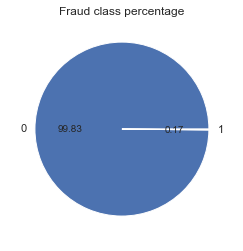

In [7]:
count_classes = pd.value_counts(y_train['Class'], sort = True).sort_index()
#count_classes.plot(kind = 'pie')
plt.pie(count_classes, labels=[0, 1], autopct='%.2f')
plt.title("Fraud class percentage")

### 1.3 Feature distribution <a id="1.3feature-distribution"></a>

In [8]:
X_train_normal = X_train[y_train['Class']==0].rename(columns = {'Time':'Normal_Time', 'Amount':'Normal_Amount'})
X_train_fraud = X_train[y_train['Class']==1].rename(columns = {'Time':'Fraud_Time', 'Amount':'Fraud_Amount'})

### _Time distribution_

(0, 1.2e-05)

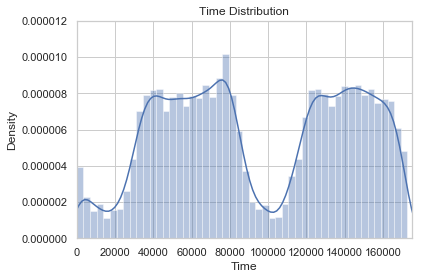

In [9]:
sns.set_style('whitegrid')
sns.distplot(X_train["Time"]).set_title('Time Distribution')
plt.xlabel("Time")
plt.ylabel("Density")
plt.xlim(0,175000)
plt.ylim(0,0.000012)

(0, 175000)

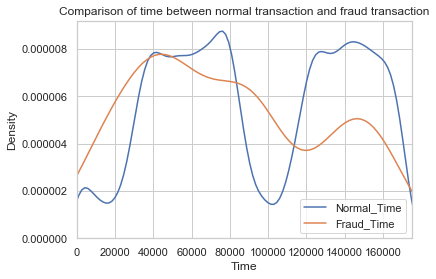

In [10]:
sns.kdeplot(X_train_normal["Normal_Time"])
sns.kdeplot(X_train_fraud["Fraud_Time"]).set_title("Comparison of time between normal transaction and fraud transaction")
plt.xlabel("Time")
plt.ylabel("Density")
plt.xlim(0,175000)

### _Amount distribution_

(0, 1590.9039710147865)

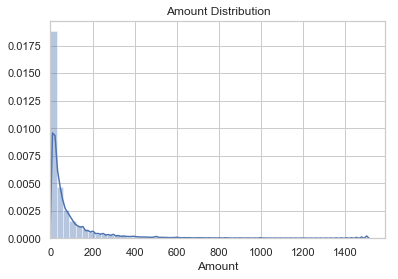

In [11]:
Amount = X_train[X_train['Amount']<=1500]['Amount']

sns.distplot(Amount).set_title('Amount Distribution')
plt.xlim(0)

(0, 1500)

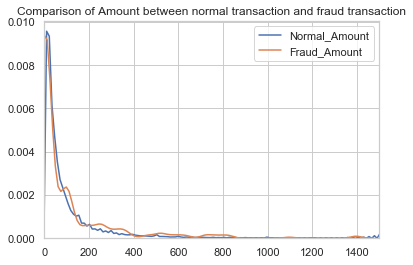

In [12]:
sns.kdeplot(X_train_normal[X_train_normal['Normal_Amount']<=1500]['Normal_Amount'])
sns.kdeplot(X_train_fraud[X_train_fraud['Fraud_Amount']<=1500]['Fraud_Amount'])
plt.title("Comparison of Amount between normal transaction and fraud transaction")
plt.xlim(0,1500)

### _Distribution of Time and Amount_

(0, 400)

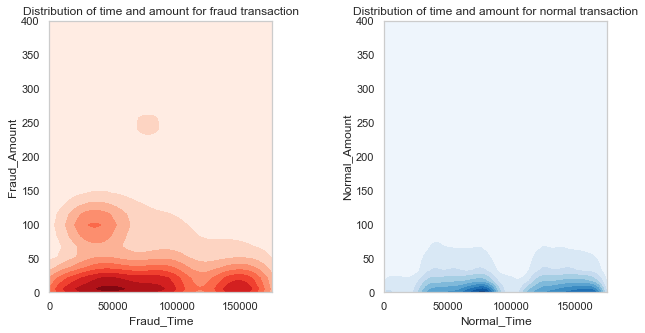

In [13]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.kdeplot(X_train_fraud[X_train_fraud['Fraud_Amount']<=1500]['Fraud_Time'], 
            X_train_fraud[X_train_fraud['Fraud_Amount']<=1500]['Fraud_Amount'], cmap="Reds", shade=True)
plt.title("Distribution of time and amount for fraud transaction")
plt.xlim(0,175000)
plt.ylim(0,400)
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,2)
sns.kdeplot(X_train_normal[X_train_normal['Normal_Amount']<=1500]['Normal_Time'], 
            X_train_normal[X_train_normal['Normal_Amount']<=1500]['Normal_Amount'], cmap="Blues", shade=True)
plt.title("Distribution of time and amount for normal transaction")
plt.xlim(0,175000)
plt.ylim(0,400)

### _Distribution histogramme of all features_

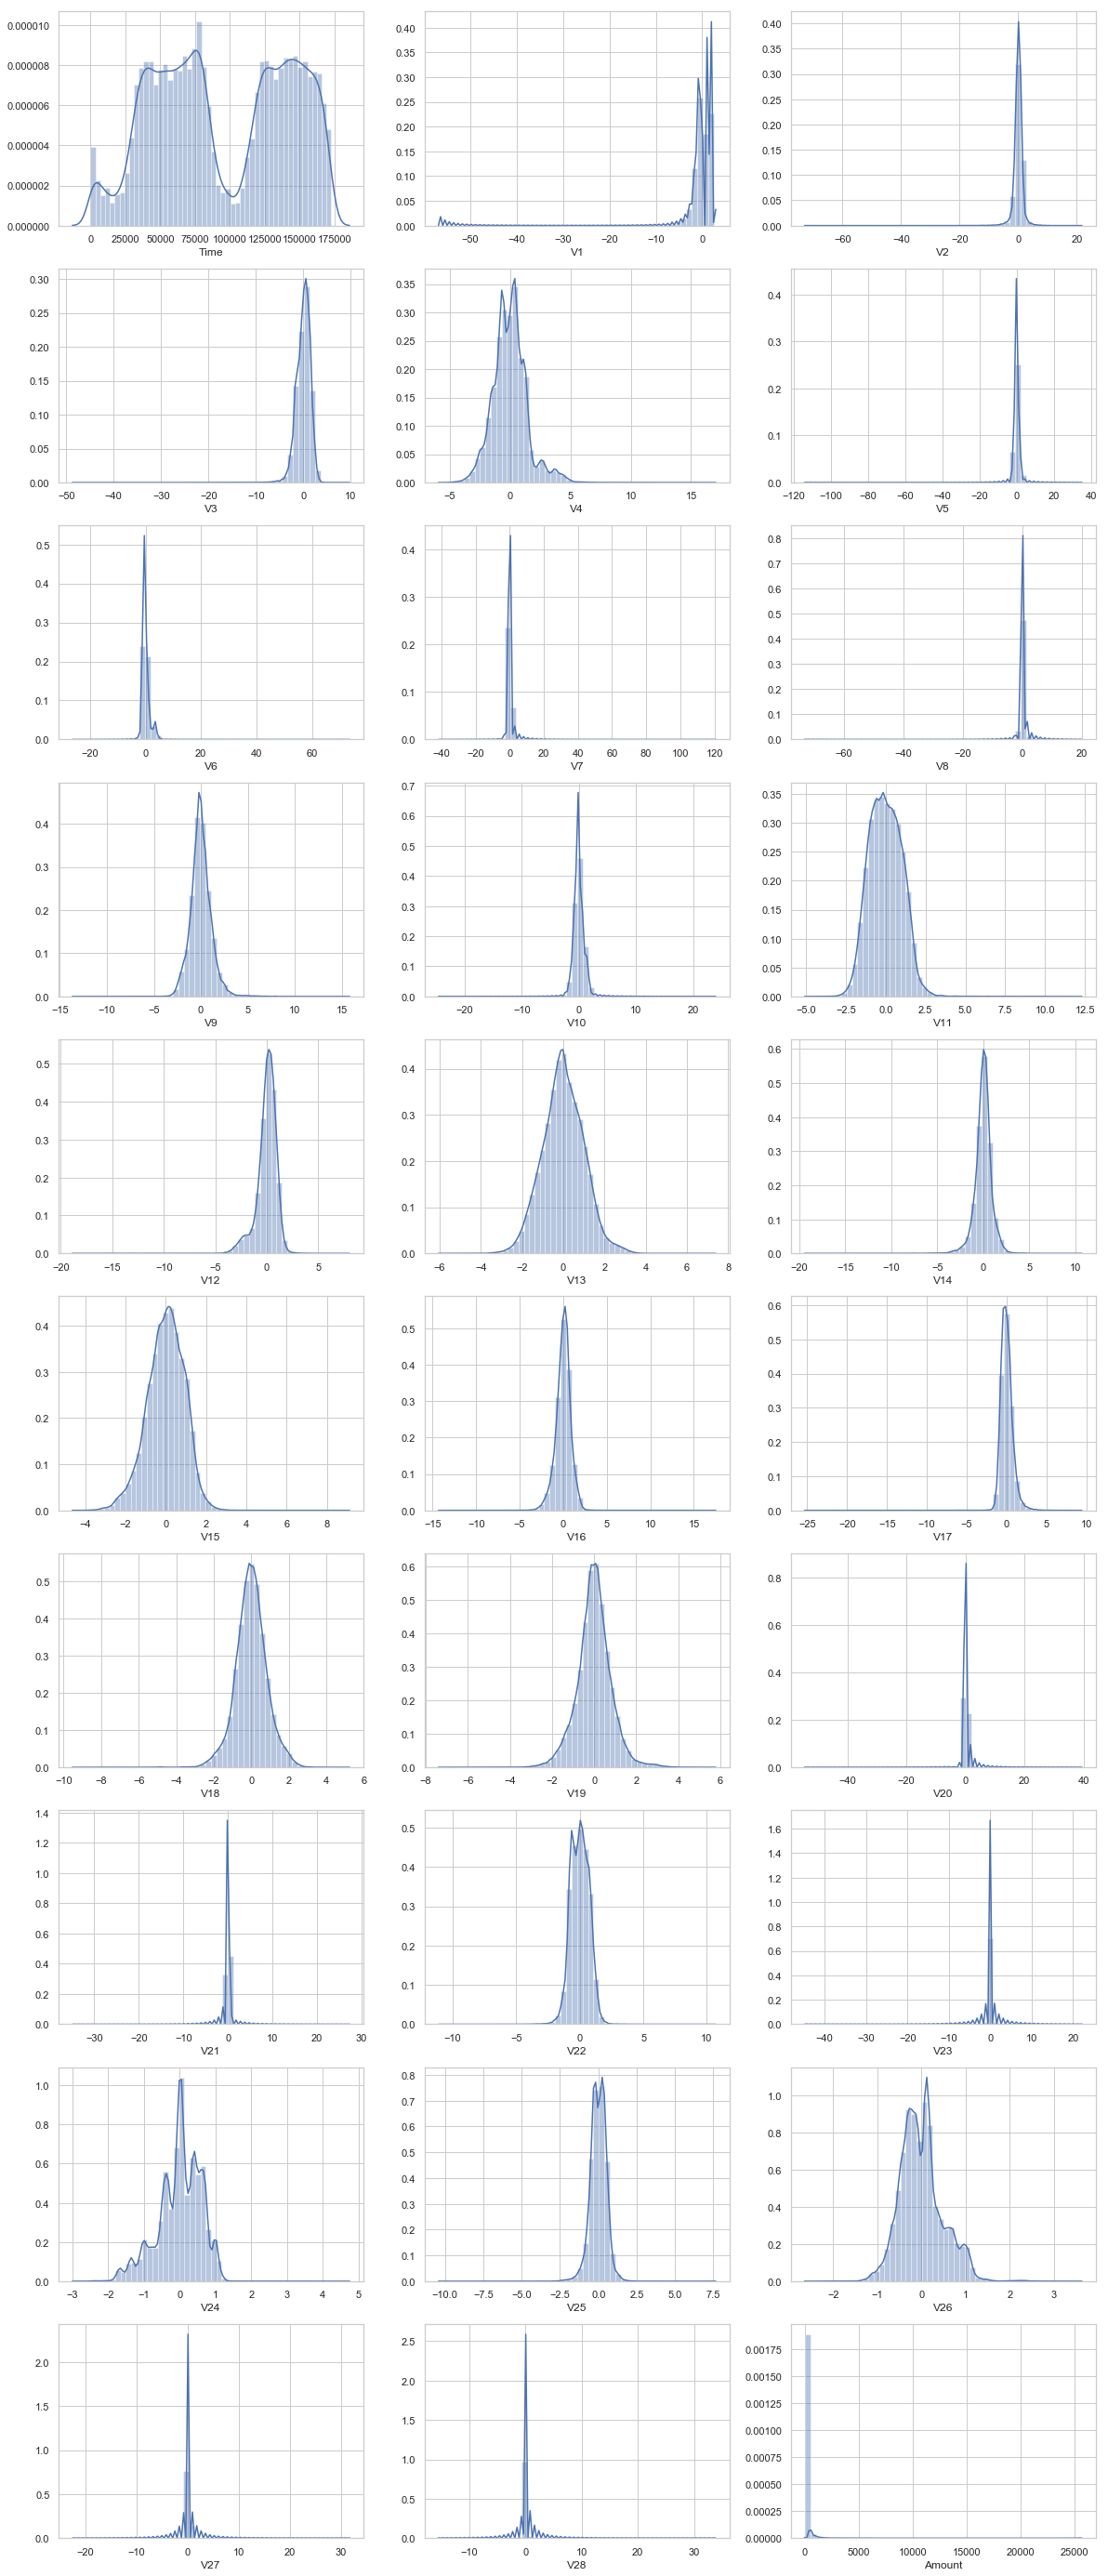

In [14]:
plt.figure(figsize=(20,50))
for i, f in enumerate(X_train.columns):
    plt.subplot(10,3,i+1)
    sns.distplot(X_train[f])

### 1.4 Correlation matrix <a id="1.4correlation-matrix"></a>
### _Correlation matrix of different classes_

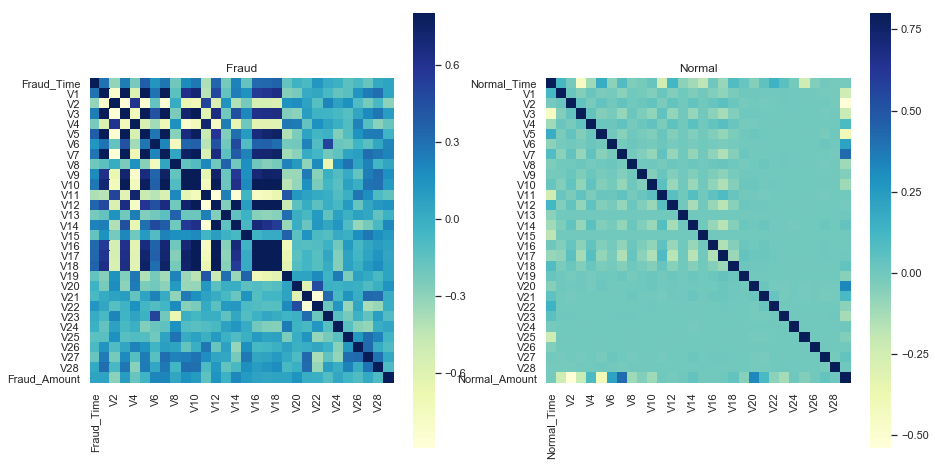

In [15]:
##Before Sampling
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 15, 8))

sns.heatmap(X_train_fraud.corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(X_train_normal.corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

### _Correlation matrix before and after undersampling_

In [16]:
#After undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_resampled = pd.DataFrame(data=X_resampled, columns=X_train.columns)
y_resampled = pd.DataFrame(data=y_resampled, columns=['Class'])

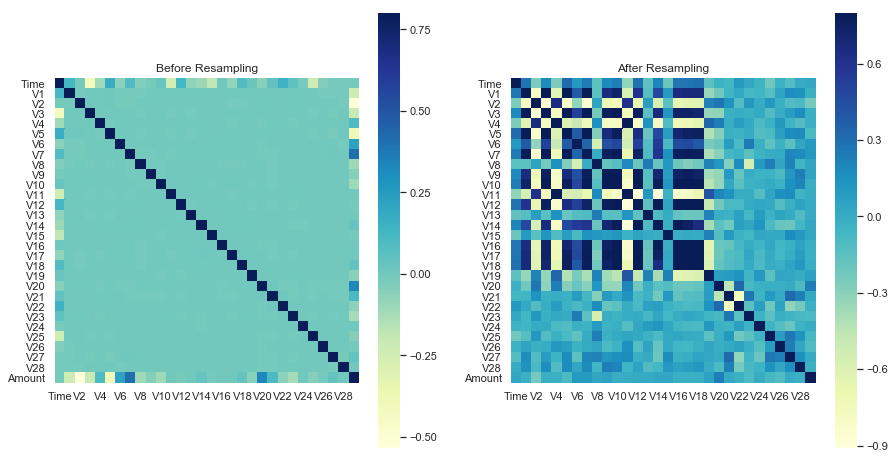

In [17]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 15, 8))

sns.heatmap(X_train.corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Before Resampling')

sns.heatmap(X_resampled.corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('After Resampling')

plt.show()

### 1.5 T-SNE for undersampling data <a id="1.5t-sne-for-undersampling-data"></a>

In [18]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X_resampled[0:])

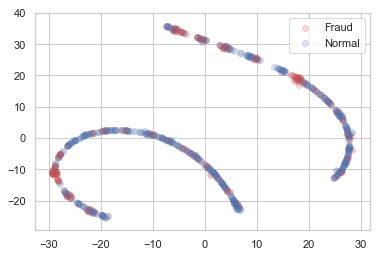

In [19]:
plt.scatter(X_2d[y_resampled['Class'] == 1, 0], X_2d[y_resampled['Class'] == 1, 1], c='r', label='Fraud', alpha=0.2)
plt.scatter(X_2d[y_resampled['Class'] == 0, 0], X_2d[y_resampled['Class'] == 0, 1], c='b', label='Normal', alpha=0.2)
plt.legend(['Fraud', 'Normal'])

## 2. Machine learning <a id="machine-learning"></a>

In [20]:
def print_metrics(y_true, y_pred):
    print ("Precision: %.4f" % (precision_score(y_true, y_pred)))
    print ("Recall: %.4f" % (recall_score(y_true, y_pred)))
    print ("F1: %.4f" % (f1_score(y_true, y_pred)))
    print ("Confusion matrix:")
    print (confusion_matrix(y_true, y_pred))
    return


def aucpr(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    indices = np.argsort(precision)
    precision = precision[indices]
    recall = recall[indices]
    return auc(precision, recall)


def evaluate(y_train, y_test, y_train_pred, y_test_pred, y_train_pred_dropV, y_test_pred_dropV):
    if len(y_train_pred) > 0:
        train_prec.append(precision_score(y_train, y_train_pred))
        train_rec.append(recall_score(y_train, y_train_pred))
        train_f1.append(f1_score(y_train, y_train_pred))
        train_aucpr.append(aucpr(y_train, y_train_pred))
    
    if len(y_train_pred_dropV) > 0:
        train_prec_dropV.append(precision_score(y_train, y_train_pred_dropV))
        train_rec_dropV.append(recall_score(y_train, y_train_pred_dropV))
        train_f1_dropV.append(f1_score(y_train, y_train_pred_dropV))
        train_aucpr_dropV.append(aucpr(y_train, y_train_pred_dropV))
    
    if len(y_test_pred) > 0:
        test_prec.append(precision_score(y_test, y_test_pred))
        test_rec.append(recall_score(y_test, y_test_pred))
        test_f1.append(f1_score(y_test, y_test_pred))
        test_aucpr.append(aucpr(y_test, y_test_pred))
    
    if len(y_test_pred_dropV) > 0:
        test_prec_dropV.append(precision_score(y_test, y_test_pred_dropV))
        test_rec_dropV.append(recall_score(y_test, y_test_pred_dropV))
        test_f1_dropV.append(f1_score(y_test, y_test_pred_dropV))
        test_aucpr_dropV.append(aucpr(y_test, y_test_pred_dropV))
    

def draw(x, x_label, mv_gaussian=False, dropV=False):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))    
    if not mv_gaussian:
        axes[0][0].plot(x, train_prec, label='train without dropping features')
        axes[0][0].plot(x, test_prec, label='test without dropping features')
        axes[0][1].plot(x, train_rec, label='train without dropping features')
        axes[0][1].plot(x, test_rec, label='test without dropping features')
        axes[1][0].plot(x, train_f1, label='train without dropping features')
        axes[1][0].plot(x, test_f1, label='test without dropping features')
        axes[1][1].plot(x, train_aucpr, label='train without dropping features')
        axes[1][1].plot(x, test_aucpr, label='test without dropping features')
        
        if dropV:
            axes[0][0].plot(x, train_prec_dropV, label='train with dropping features')
            axes[0][0].plot(x, test_prec_dropV, label='test with dropping features')
            axes[0][1].plot(x, train_rec_dropV, label='train with dropping features')
            axes[0][1].plot(x, test_rec_dropV, label='test with dropping features')
            axes[1][0].plot(x, train_f1_dropV, label='train with dropping features')
            axes[1][0].plot(x, test_f1_dropV, label='test with dropping features')
            axes[1][1].plot(x, train_aucpr_dropV, label='train with dropping features')
            axes[1][1].plot(x, test_aucpr_dropV, label='test with dropping features')
        
        fig.suptitle("train and test with or without dropping features")
    else:
        axes[0][0].semilogx(x, test_prec, label='test without dropping features')
        axes[0][1].semilogx(x, test_rec, label='test without dropping features')
        axes[1][0].semilogx(x, test_f1, label='test without dropping features')
        axes[1][1].semilogx(x, test_aucpr, label='test without dropping features')
        
        if dropV:
            axes[0][0].semilogx(x, test_prec_dropV, label='test with dropping features')
            axes[0][1].semilogx(x, test_rec_dropV, label='test with dropping features')
            axes[1][0].semilogx(x, test_f1_dropV, label='test with dropping features')
            axes[1][1].semilogx(x, test_aucpr_dropV, label='test with dropping features')
        
        fig.suptitle("test with or without dropping features")
        
    axes[0][0].set_ylabel("Precision")
    axes[0][0].set_xlabel(x_label)
    axes[0][0].legend()
    axes[0][1].set_ylabel("Recall")
    axes[0][1].set_xlabel(x_label)
    axes[0][1].legend()
    axes[1][0].set_ylabel("F1")
    axes[1][0].set_xlabel(x_label)
    axes[1][0].legend()
    axes[1][1].set_ylabel("AUCPR")
    axes[1][1].set_xlabel(x_label)
    axes[1][1].legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 2.1 Feature engineering <a id="2.1feature-engineering"></a>

In [21]:
data.drop(['Time', 'Amount'], axis=1, inplace=True)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

rf = RandomForestClassifier(n_estimators=100 , criterion='entropy', n_jobs=3, random_state=0)
rf.fit(X, y)
sorted(zip(rf.feature_importances_, X.columns), key=lambda x: -x[0])

[(0.18240053481425814, 'V17'),
 (0.14446696639991408, 'V14'),
 (0.13234432564343263, 'V12'),
 (0.10144749886503578, 'V10'),
 (0.07745576059833321, 'V11'),
 (0.042240973230260374, 'V16'),
 (0.0389204552302894, 'V4'),
 (0.03744517002582191, 'V3'),
 (0.029923253055630834, 'V7'),
 (0.027871587945440472, 'V9'),
 (0.020816197155352326, 'V18'),
 (0.012702062204011521, 'V19'),
 (0.01204392865413024, 'V8'),
 (0.01195397426630823, 'V21'),
 (0.011785187869373942, 'V26'),
 (0.011574249107405848, 'V20'),
 (0.011004386133911468, 'V1'),
 (0.01059821400203368, 'V27'),
 (0.009946781922962153, 'V2'),
 (0.008923898903588605, 'V6'),
 (0.008809189891428816, 'V28'),
 (0.008688311090286938, 'V15'),
 (0.008686891678194057, 'V5'),
 (0.008595315312412704, 'V13'),
 (0.007961248826809937, 'V22'),
 (0.007293445325850915, 'V25'),
 (0.007090864756069252, 'V23'),
 (0.007009327091452588, 'V24')]

**We will compare the performance of dropping following features for all algorithms below**

['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24']

## 2.2 Supervised learning - Baseline <a id="2.2supervised-learning-baseline"></a>
### 2.2.1 Undersampling+LR <a id="2.2.1undersampling-lr"></a>

In [22]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv', names=['Class'])
y_test = pd.read_csv('data/y_test.csv', names=['Class'])

X_train.drop(['Time'], axis=1, inplace=True)
X_test.drop(['Time'], axis=1, inplace=True)

scaler = StandardScaler()
X_train['normAmount'] = scaler.fit_transform(np.array(X_train['Amount']).reshape(-1, 1))
X_test['normAmount'] = scaler.transform(np.array(X_test['Amount']).reshape(-1, 1))

X_train.drop(['Amount'], axis=1, inplace=True)
X_test.drop(['Amount'], axis=1, inplace=True)

# drop features with low feature importances
X_train_dropV = X_train.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1)
X_test_dropV = X_test.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1)

### _Train on undersampling data and predict_

In [23]:
np.random.seed(1234)
normal_indices = y_train[y_train['Class']==0].index
fraud_indices = y_train[y_train['Class']==1].index
num_fraud = len(fraud_indices)
random_normal_indices = np.random.choice(normal_indices, num_fraud, replace=False)
undersample_indices = np.concatenate([fraud_indices, random_normal_indices])

undersample_X_train = X_train.iloc[undersample_indices, :]
undersample_X_train_dropV = X_train_dropV.iloc[undersample_indices, :]
undersample_y_train = y_train.iloc[undersample_indices, :]

lr = LogisticRegression(C=0.01, solver='lbfgs')
lr.fit(undersample_X_train, undersample_y_train)
y_train_score = lr.predict_proba(X_train)[:, 1]
y_test_score = lr.predict_proba(X_test)[:, 1]

lr_dropV = LogisticRegression(C=0.01, solver='lbfgs')
lr_dropV.fit(undersample_X_train_dropV, undersample_y_train)
y_train_score_dropV = lr_dropV.predict_proba(X_train_dropV)[:, 1]
y_test_score_dropV = lr_dropV.predict_proba(X_test_dropV)[:, 1]

### _Tuning on decision function threshold_

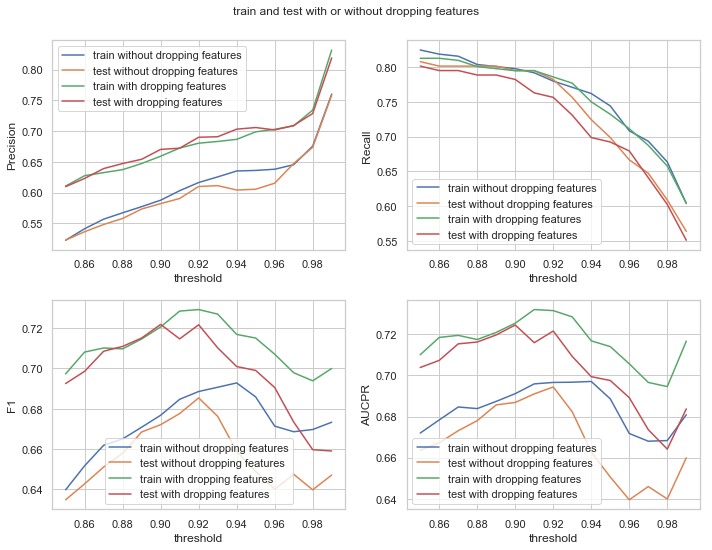

In [24]:
train_prec = []
test_prec = []
train_rec = []
test_rec = []
train_f1 = []
test_f1 = []
train_aucpr = []
test_aucpr = []

train_prec_dropV = []
test_prec_dropV = []
train_rec_dropV = []
test_rec_dropV = []
train_f1_dropV = []
test_f1_dropV = []
train_aucpr_dropV = []
test_aucpr_dropV = []

for threshold in np.arange(0.85, 0.99, 0.01):
    y_train_pred = np.array([sc>threshold for sc in y_train_score], dtype=int)
    y_test_pred = np.array([sc>threshold for sc in y_test_score], dtype=int)
    y_train_pred_dropV = np.array([sc>threshold for sc in y_train_score_dropV], dtype=int)
    y_test_pred_dropV = np.array([sc>threshold for sc in y_test_score_dropV], dtype=int)

    evaluate(y_train, y_test, y_train_pred, y_test_pred, y_train_pred_dropV, y_test_pred_dropV)
    
draw(np.arange(0.85, 0.99, 0.01), 'threshold', False, True)

In [25]:
y_train_prob_lr = y_train_score_dropV
y_train_pred_lr = np.array([sc>0.9 for sc in y_train_prob_lr], dtype=int)

y_test_prob_lr = y_test_score_dropV
y_test_pred_lr = np.array([sc>0.9 for sc in y_test_prob_lr], dtype=int)

## 2.3 Unsupervised learning <a id="2.3unsupervised-learning"></a>
### 2.3.1 Local Outlier Factor <a id="2.3.1local-outlier-factor"></a>
### _Tuning on number of neighbors_

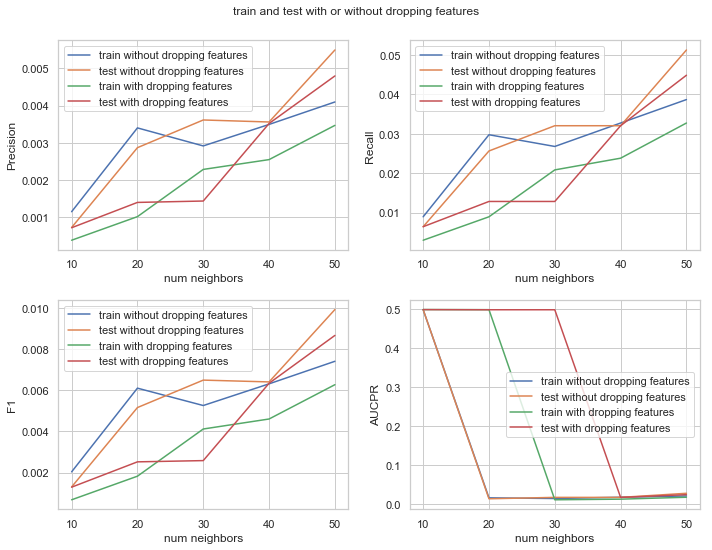

In [26]:
train_prec = []
test_prec = []
train_rec = []
test_rec = []
train_f1 = []
test_f1 = []
train_aucpr = []
test_aucpr = []

train_prec_dropV = []
test_prec_dropV = []
train_rec_dropV = []
test_rec_dropV = []
train_f1_dropV = []
test_f1_dropV = []
train_aucpr_dropV = []
test_aucpr_dropV = []

for neigh in [10, 20, 30, 40, 50]:
    lof = LocalOutlierFactor(n_neighbors=neigh, algorithm='auto', metric='euclidean', contamination=0.0168, novelty=True, n_jobs=3)
    lof.fit(X_train)
    
    y_train_pred = lof.predict(X_train)
    y_test_pred = lof.predict(X_test)
    y_train_pred = np.array([pred==-1 for pred in y_train_pred], dtype=int)
    y_test_pred = np.array([pred==-1 for pred in y_test_pred], dtype=int)
    
    lof_dropV = LocalOutlierFactor(n_neighbors=neigh, algorithm='auto', metric='euclidean', contamination=0.0168, novelty=True, n_jobs=3)
    lof_dropV.fit(X_train_dropV)
    
    y_train_pred_dropV = lof_dropV.predict(X_train_dropV)
    y_test_pred_dropV = lof_dropV.predict(X_test_dropV)
    y_train_pred_dropV = np.array([pred==-1 for pred in y_train_pred_dropV], dtype=int)
    y_test_pred_dropV = np.array([pred==-1 for pred in y_test_pred_dropV], dtype=int)
    
    evaluate(y_train, y_test, y_train_pred, y_test_pred, y_train_pred_dropV, y_test_pred_dropV)
    
draw([10, 20, 30, 40, 50], 'num neighbors', False, True)

In [27]:
lof_dropV = LocalOutlierFactor(n_neighbors=30, algorithm='auto', metric='euclidean', contamination=0.0168, novelty=True, n_jobs=3)
lof_dropV.fit(X_train_dropV)

LocalOutlierFactor(algorithm='auto', contamination=0.0168, leaf_size=30,
          metric='euclidean', metric_params=None, n_jobs=3, n_neighbors=30,
          novelty=True, p=2)

In [28]:
y_train_pred_lof = lof_dropV.predict(X_train_dropV)
y_train_pred_lof = np.array([pred==-1 for pred in y_train_pred_lof], dtype=int)

y_test_pred_lof = lof_dropV.predict(X_test_dropV)
y_test_pred_lof = np.array([pred==-1 for pred in y_test_pred_lof], dtype=int)

### 2.3.2 One-Class SVM <a id="2.3.2one-class-svm"></a>
### _Tuning on gamma_

In [ ]:
# This part takes too much time to give results, so we won't execute the code but just leave it here.
# SVM waits for a more powerful engine

In [ ]:
train_prec = []
test_prec = []
train_rec = []
test_rec = []
train_f1 = []
test_f1 = []
train_aucpr = []
test_aucpr = []

train_prec_dropV = []
test_prec_dropV = []
train_rec_dropV = []
test_rec_dropV = []
train_f1_dropV = []
test_f1_dropV = []
train_aucpr_dropV = []
test_aucpr_dropV = []

for ga in np.arange(0.1, 1, 0.2):
    ocsvm = OneClassSVM(gamma=ga, nu=0.5)
    ocsvm.fit(X_train)

    y_train_pred = ocsvm.predict(X_train)
    y_test_pred = ocsvm.predict(X_test)
    y_train_pred = np.array([pred==-1 for pred in y_train_pred], dtype=int)
    y_test_pred = np.array([pred==-1 for pred in y_test_pred], dtype=int)
    
    ocsvm_dropV = OneClassSVM(gamma=ga, nu=0.5)
    ocsvm_dropV.fit(X_train_dropV)

    y_train_pred_dropV = ocsvm_dropV.predict(X_train_dropV)
    y_test_pred_dropV = ocsvm_dropV.predict(X_test_dropV)
    y_train_pred_dropV = np.array([pred==-1 for pred in y_train_pred_dropV], dtype=int)
    y_test_pred_dropV = np.array([pred==-1 for pred in y_test_pred_dropV], dtype=int)
    
    evaluate(y_train, y_test, y_train_pred, y_test_pred, y_train_pred_dropV, y_test_pred_dropV)
    
draw(np.arange(0.1, 1, 0.2), 'gamma', False, True)

### 2.3.3 Isolation Forest <a id="2.3.3isolation-forest"></a>
### _Construct dataset without dropping or scaling 'Amount'_

In [29]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv', names=['Class'])
y_test = pd.read_csv('data/y_test.csv', names=['Class'])

X_train.drop(['Time'], axis=1, inplace=True)
X_test.drop(['Time'], axis=1, inplace=True)

# drop features with low feature importances
X_train_dropV = X_train.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1)
X_test_dropV = X_test.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1)

### _Tuning on max samples_

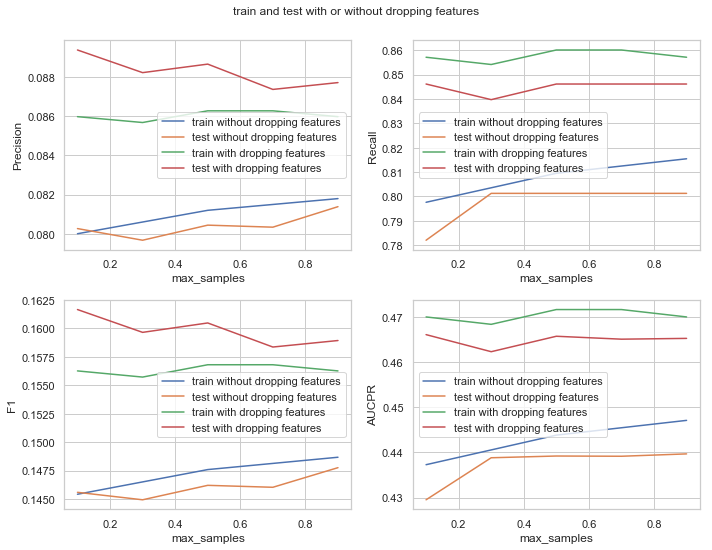

In [30]:
train_prec = []
test_prec = []
train_rec = []
test_rec = []
train_f1 = []
test_f1 = []
train_aucpr = []
test_aucpr = []

train_prec_dropV = []
test_prec_dropV = []
train_rec_dropV = []
test_rec_dropV = []
train_f1_dropV = []
test_f1_dropV = []
train_aucpr_dropV = []
test_aucpr_dropV = []

for ms in np.arange(0.1, 1, 0.2):
    isof = IsolationForest(n_estimators=100, contamination=0.0168, behaviour='new', max_samples=ms, n_jobs=3, random_state=0)
    isof.fit(X_train)
    
    y_train_pred = isof.predict(X_train)
    y_test_pred = isof.predict(X_test)
    y_train_pred = np.array([pred==-1 for pred in y_train_pred], dtype=int)
    y_test_pred = np.array([pred==-1 for pred in y_test_pred], dtype=int)
    
    isof_dropV = IsolationForest(n_estimators=100, contamination=0.0168, behaviour='new', max_samples=ms, n_jobs=3, random_state=0)
    isof_dropV.fit(X_train_dropV)
    
    y_train_pred_dropV = isof_dropV.predict(X_train_dropV)
    y_test_pred_dropV = isof_dropV.predict(X_test_dropV)
    y_train_pred_dropV = np.array([pred==-1 for pred in y_train_pred_dropV], dtype=int)
    y_test_pred_dropV = np.array([pred==-1 for pred in y_test_pred_dropV], dtype=int)
    
    evaluate(y_train, y_test, y_train_pred, y_test_pred, y_train_pred_dropV, y_test_pred_dropV)
    
draw(np.arange(0.1, 1, 0.2), 'max_samples', False, True)

In [31]:
isof_dropV = IsolationForest(n_estimators=100, contamination=0.0168, behaviour='new', max_samples=0.9, n_jobs=3, random_state=0)
isof_dropV.fit(X_train_dropV)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.0168,
        max_features=1.0, max_samples=0.9, n_estimators=100, n_jobs=3,
        random_state=0, verbose=0)

In [32]:
y_train_pred_if = isof_dropV.predict(X_train_dropV)
y_train_pred_if = np.array([pred==-1 for pred in y_train_pred_if], dtype=int)

y_test_pred_if = isof_dropV.predict(X_test_dropV)
y_test_pred_if = np.array([pred==-1 for pred in y_test_pred_if], dtype=int)

### 2.3.4 Multivariate Gaussian <a id="2.3.4multivariate-gaussian"></a>

In [33]:
class MultiVariateGaussian(object):
    
    def __init__(self, data):
        self.mu = np.mean(data, axis=0)
        self.sigma = np.cov(data.T)
        self.model = multivariate_normal(mean=self.mu, cov=self.sigma)

    def predict(self, sample):
        return self.model.pdf(sample)

### _Extract 70% normal to train and 30% normal+100% fraud to test_

In [34]:
normal_indices = y_train[y_train['Class']==0].index
fraud_indices = y_train[y_train['Class']==1].index

# training set contains only normal
normal_X_train = X_train.iloc[normal_indices, :]

# test sert contains a part of normal and all fraud
fraud_X_train = X_train.iloc[fraud_indices, :]
X_test = pd.concat([X_test, fraud_X_train])
y_test = pd.concat([y_test, y_train[y_train['Class']==1]])

# drop features with low feature importances
normal_X_train_dropV = normal_X_train.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1)
X_test_dropV = X_test.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1)

### _Tuning on decision function threshold_

In [35]:
mn = MultiVariateGaussian(normal_X_train)
y_train_score = mn.predict(normal_X_train)
y_test_score = mn.predict(X_test)

mn_dropV = MultiVariateGaussian(normal_X_train_dropV)
y_train_score_dropV = mn_dropV.predict(normal_X_train_dropV)
y_test_score_dropV = mn_dropV.predict(X_test_dropV)

y_train = y_train[y_train['Class']==0]

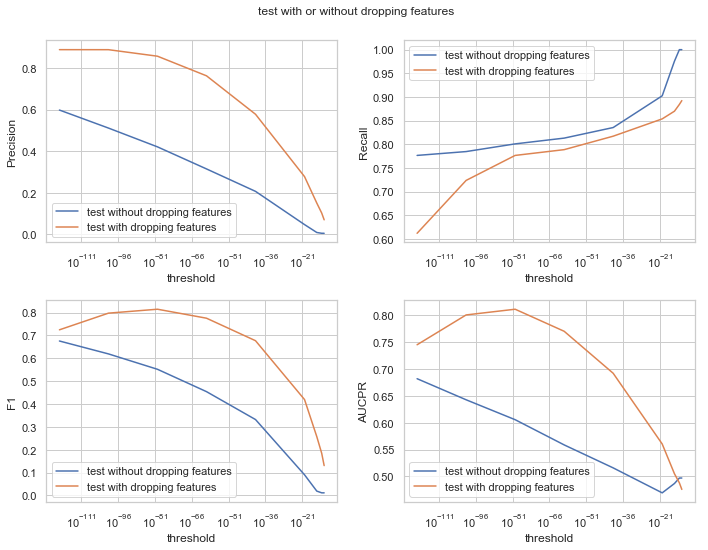

In [36]:
test_prec = []
test_rec = []
test_f1 = []
test_aucpr = []

test_prec_dropV = []
test_rec_dropV = []
test_f1_dropV = []
test_aucpr_dropV = []

for threshold in [1e-120, 1e-100, 1e-80, 1e-60, 1e-40, 1e-20, 1e-15, 1e-13, 1e-12]:
    y_test_pred = np.array([sc<=threshold for sc in y_test_score], dtype=int)
    y_test_pred_dropV = np.array([sc<=threshold for sc in y_test_score_dropV], dtype=int)
    
    evaluate(y_train, y_test, [], y_test_pred, [], y_test_pred_dropV)

draw([1e-120, 1e-100, 1e-80, 1e-60, 1e-40, 1e-20, 1e-15, 1e-13, 1e-12], 'threshold', True, True)

In [37]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')

X_train.drop(['Time'], axis=1, inplace=True)
X_test.drop(['Time'], axis=1, inplace=True)

# drop features with low feature importances
X_train_dropV = X_train.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1)
X_test_dropV = X_test.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1)

In [38]:
y_train_prob_mg = mn_dropV.predict(X_train_dropV)
y_train_pred_mg = np.array([sc<=1e-80 for sc in y_train_prob_mg], dtype=int)

y_test_prob_mg = mn_dropV.predict(X_test_dropV)
y_test_pred_mg = np.array([sc<=1e-80 for sc in y_test_prob_mg], dtype=int)

## 2.4 Semi-supervised learning <a id="2.4semi-supervised-learning"></a>
### 2.4.1 Auto-encoder <a id="2.4.1auto-encoder"></a>

In [39]:
def autoencoder_x(train_x, val_x):
    '''get autoencoder for x'''
    x_train_norm = preprocessing.MinMaxScaler().fit_transform(train_x.values)
    x_val_norm = preprocessing.MinMaxScaler().fit_transform(val_x.values)
    train = hidden_representation.predict(x_train_norm)
    val = hidden_representation.predict(x_val_norm)
    return train, val


def tsne_plot(x1, y1):
    '''plot t-sne graph'''
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1==0), 0], X_t[np.where(y1==0),1], 
               marker='o',color='g', alpha=0.8, label='Non fraud')
    plt.scatter(X_t[np.where(y1==1), 0], X_t[np.where(y1==1),1], 
               marker='o',color='r', alpha=0.8, label='fraud')
    
    plt.legend(loc='best')
    plt.show()

In [40]:
data = pd.read_csv("data/creditcard.csv")
data["Time"] = data["Time"].apply(lambda x:x/3600%24)

We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

In [41]:
## input layer
input_layer = Input(shape=(data.shape[1]-1,))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(data.shape[1]-1, activation='relu')(decoded)

In [42]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [43]:
X = data.drop(["Class"], axis=1)
y = data["Class"].values

X_scale = preprocessing.MinMaxScaler().fit_transform(X.values)
X_norm, X_fraud = X_scale[y==0], X_scale[y==1]

In [44]:
#trian this model
autoencoder.fit(X_norm[0:2000], X_norm[0:2000], batch_size=256,
               epochs = 30, shuffle=True, validation_split=0.20)

Train on 1600 samples, validate on 400 samples
Epoch 1/30
1600/1600 [==============================] - 2s 1ms/step - loss: 0.7681 - val_loss: 0.5115
Epoch 2/30
1600/1600 [==============================] - 0s 52us/step - loss: 0.4744 - val_loss: 0.3220
Epoch 3/30
1600/1600 [==============================] - 0s 59us/step - loss: 0.3000 - val_loss: 0.2187
Epoch 4/30
1600/1600 [==============================] - 0s 58us/step - loss: 0.2130 - val_loss: 0.1652
Epoch 5/30
1600/1600 [==============================] - 0s 64us/step - loss: 0.1740 - val_loss: 0.1491
Epoch 6/30
1600/1600 [==============================] - 0s 52us/step - loss: 0.1695 - val_loss: 0.1638
Epoch 7/30
1600/1600 [==============================] - 0s 52us/step - loss: 0.1646 - val_loss: 0.1328
Epoch 8/30
1600/1600 [==============================] - 0s 52us/step - loss: 0.1370 - val_loss: 0.1250
Epoch 9/30
1600/1600 [==============================] - 0s 40us/step - loss: 0.1516 - val_loss: 0.1369
Epoch 10/30
1600/1600 [====

In [45]:
# obtain the latent representations
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [46]:
norm_hid_rep = hidden_representation.predict(X_norm)[:3000]
fraud_hid_rep = hidden_representation.predict(X_fraud)

Here we can visualize latent representation by t-sne.

In [47]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis=0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

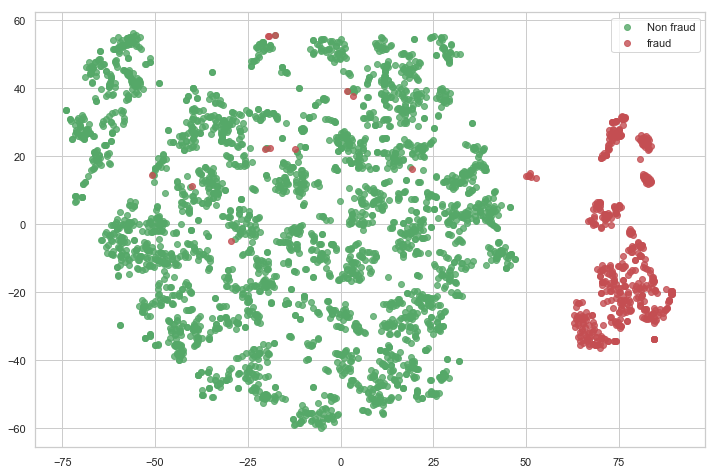

In [48]:
tsne_plot(rep_x, rep_y)

We can observe that now fraud and non-fraud transactions are pretty visibile and are linearly separable.

### 2.4.2 Linear classifier prediction <a id="2.4.2linear-classifier-prediction"></a>
Now we use a simple linear classifer on this dataset.

In [49]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv', header=None)[0]
y_test = pd.read_csv('data/y_test.csv', header=None)[0]

In [50]:
X_train, X_test = autoencoder_x(X_train, X_test)

Now we tune the hyper-parameter for the model

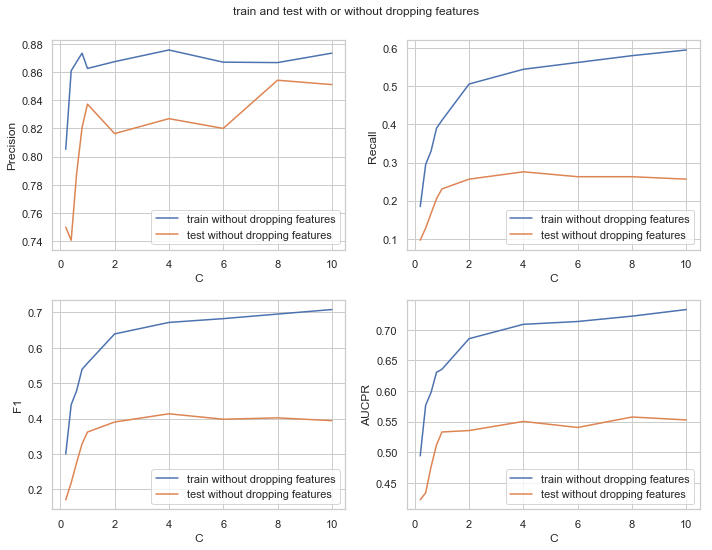

In [51]:
train_prec = []
test_prec = []
train_rec = []
test_rec = []
train_f1 = []
test_f1 = []
train_aucpr = []
test_aucpr = []

for c in [0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8, 10]:
    lr = LogisticRegression(C=c, solver='lbfgs')
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    
    evaluate(y_train, y_test, y_train_pred, y_test_pred, [], [])
    
draw([0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8, 10], 'C', False, False)

tuning on threshold for LR with C=10

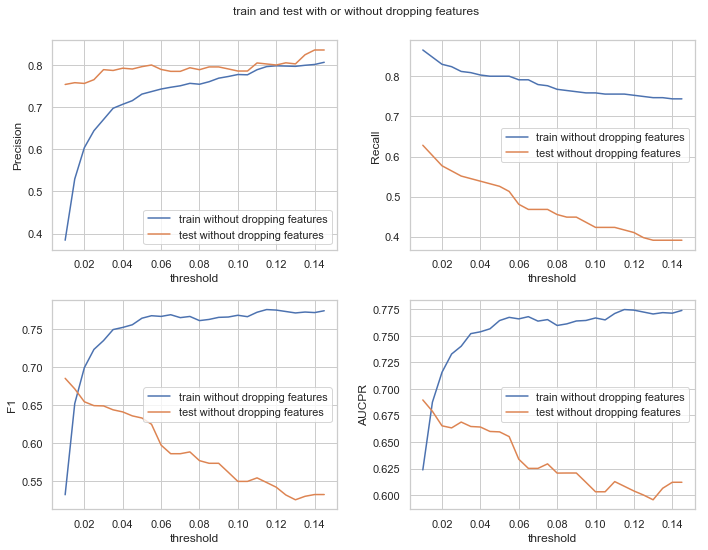

In [52]:
lr = LogisticRegression(C=10, solver='lbfgs')
lr.fit(X_train, y_train)
y_train_score = lr.predict_proba(X_train)[:, 1]
y_test_score = lr.predict_proba(X_test)[:, 1]

train_prec = []
test_prec = []
train_rec = []
test_rec = []
train_f1 = []
test_f1 = []
train_aucpr = []
test_aucpr = []
    
for threshold in np.arange(1., 15., 0.5) * 1e-2:
    y_train_pred = np.array([sc>threshold for sc in y_train_score], dtype=int)
    y_test_pred = np.array([sc>threshold for sc in y_test_score], dtype=int)

    evaluate(y_train, y_test, y_train_pred, y_test_pred, [], [])
    
draw(np.arange(1., 15., 0.5) * 1e-2, 'threshold', False, False)

In [53]:
y_train_prob_ae = y_train_score
y_train_pred_ae = np.array([sc>1e-2 for sc in y_train_prob_ae], dtype=int)

y_test_prob_ae = y_test_score
y_test_pred_ae = np.array([sc>1e-2 for sc in y_test_prob_ae], dtype=int)

## 3. Evaluation <a id="evaluation"></a>

In [54]:
def draw_comparison(metric='f1', y_train=[], y_train_pred=[], y_test=[], y_test_pred=[], X_train=[], X_test=[]):
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)

    ## the data
    N = 5
    if metric == 'f1':
        train = [f1_score(y_train, y_train_pred[0]), f1_score(y_train, y_train_pred[1]), \
                 f1_score(y_train, y_train_pred[2]), f1_score(y_train, y_train_pred[3]), \
                 f1_score(y_train, y_train_pred[4])]
        test = [f1_score(y_test, y_test_pred[0]), f1_score(y_test, y_test_pred[1]), \
                f1_score(y_test, y_test_pred[2]), f1_score(y_test, y_test_pred[3]), \
                f1_score(y_test, y_test_pred[4])]
        ax.set_ylabel('F1 Score')
    elif metric == 'prauc':
        train = [aucpr(y_train, y_train_pred[0]), aucpr(y_train, y_train_pred[1]), \
                 aucpr(y_train, y_train_pred[2]), aucpr(y_train, y_train_pred[3]), \
                 aucpr(y_train, y_train_pred[4])]
        test = [aucpr(y_test, y_test_pred[0]), aucpr(y_test, y_test_pred[1]), \
                aucpr(y_test, y_test_pred[2]), aucpr(y_test, y_test_pred[3]), \
                aucpr(y_test, y_test_pred[4])]
        ax.set_ylabel('PR_AUC')
    elif metric == 'calinski':
        train = [calinski_harabaz_score(X_train, y_train_pred[0]), calinski_harabaz_score(X_train, y_train_pred[1]), \
                 calinski_harabaz_score(X_train, y_train_pred[2]), calinski_harabaz_score(X_train, y_train_pred[3]), \
                 calinski_harabaz_score(X_train, y_train_pred[4])]
        test = [calinski_harabaz_score(X_test, y_test_pred[0]), calinski_harabaz_score(X_test, y_test_pred[1]), \
                calinski_harabaz_score(X_test, y_test_pred[2]), calinski_harabaz_score(X_test, y_test_pred[3]), \
                calinski_harabaz_score(X_test, y_test_pred[4])]
        ax.set_ylabel('Calinski-Harabaz Score')
    elif metric == 'silhouette':
        X_train = X_train.values
        train = [silhouette_score(X_train, y_train_pred[0]), silhouette_score(X_train, y_train_pred[1]), \
                 silhouette_score(X_train, y_train_pred[2]), silhouette_score(X_train, y_train_pred[3]), \
                 silhouette_score(X_train, y_train_pred[4])]
        test = [silhouette_score(X_test, y_test_pred[0]), silhouette_score(X_test, y_test_pred[1]), \
                silhouette_score(X_test, y_test_pred[2]), silhouette_score(X_test, y_test_pred[3]), \
                silhouette_score(X_test, y_test_pred[4])]
        ax.set_ylabel('Silhouette Score')
    elif metric == 'bolong':
        train = [bolong_score(X_train, y_train_pred[0]), bolong_score(X_train, y_train_pred[1]), \
                 bolong_score(X_train, y_train_pred[2]), bolong_score(X_train, y_train_pred[3]), \
                 bolong_score(X_train, y_train_pred[4])]
        test = [bolong_score(X_test, y_test_pred[0]), bolong_score(X_test, y_test_pred[1]), \
                bolong_score(X_test, y_test_pred[2]), bolong_score(X_test, y_test_pred[3]), \
                bolong_score(X_test, y_test_pred[4])]
        ax.set_ylabel('Bolong Score')
    else:
        print('metric unknown')

    ## necessary variables
    ind = np.arange(N)
    width = 0.2     # the width of the bars

    ## the bars
    rects1 = ax.bar(ind, train, width)
    rects2 = ax.bar(ind+width, test, width)

    # axes and labels
    ax.set_title('Algo comparison', size=18)
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(['Logistic Regression', 'Local Outlier Factor',\
                        'Isolation Forest', 'Multivariate Gaussian', 'Auto-encoder+LR'])
    ax.legend(('Training', 'Test'))
    plt.show()

## 3.1 Metric with label <a id="3.1metric-with-label"></a>

In [55]:
y_train = pd.read_csv('data/y_train.csv', header=None)[0]
y_test = pd.read_csv('data/y_test.csv', header=None)[0]

### 3.1.1 Confusion matrix <a id="3.1.1confusion-matrix"></a>

In [56]:
# Confusion Matrix function
def draw_confusion_matrix(y_true, y_pred):
    M = confusion_matrix(y_true, y_pred)

    plt.imshow(M, interpolation = 'nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xticks([0, 1], [0, 1], rotation = 0)
    plt.yticks([0, 1], [0, 1])
    thresh = M.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, M[i, j], color="white" if M[i, j] > thresh else "black", size=15)
    plt.ylabel("True label")
    plt.xlabel('Predicted label')

### _Logistic Regression_

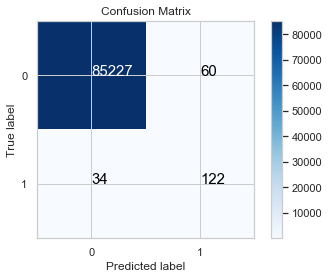

In [57]:
draw_confusion_matrix(y_test, y_test_pred_lr)

### _Local Outlier Factor_

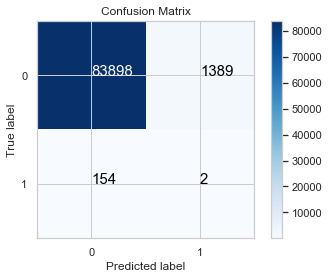

In [58]:
draw_confusion_matrix(y_test, y_test_pred_lof)

### _Isolation Forest_

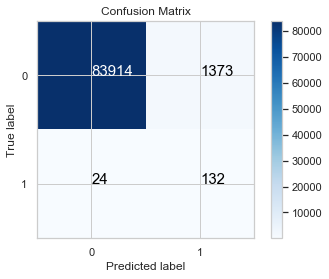

In [59]:
draw_confusion_matrix(y_test, y_test_pred_if)

### _Multivariate Gaussian_

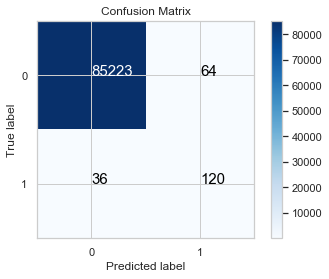

In [60]:
draw_confusion_matrix(y_test, y_test_pred_mg)

### _Auto-encoder + Logistic Regression_

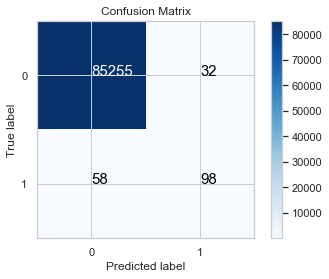

In [61]:
draw_confusion_matrix(y_test, y_test_pred_ae)

### 3.1.2 F1 score <a id="3.1.2f1-score"></a>

In [62]:
train_preds = [y_train_pred_lr, y_train_pred_lof, y_train_pred_if, y_train_pred_mg, y_train_pred_ae]
test_preds = [y_test_pred_lr, y_test_pred_lof, y_test_pred_if, y_test_pred_mg, y_test_pred_ae]

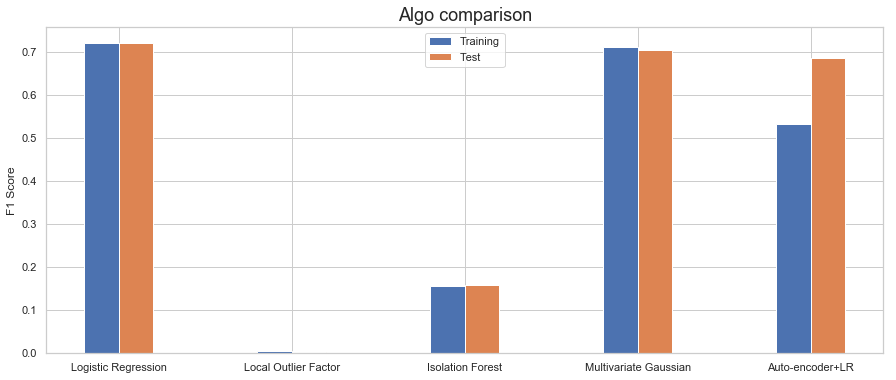

In [63]:
draw_comparison(metric='f1', y_train=y_train, y_train_pred=train_preds, y_test=y_test, y_test_pred=test_preds)

### 3.1.3 PR-AUC <a id="3.1.3pr-auc"></a>

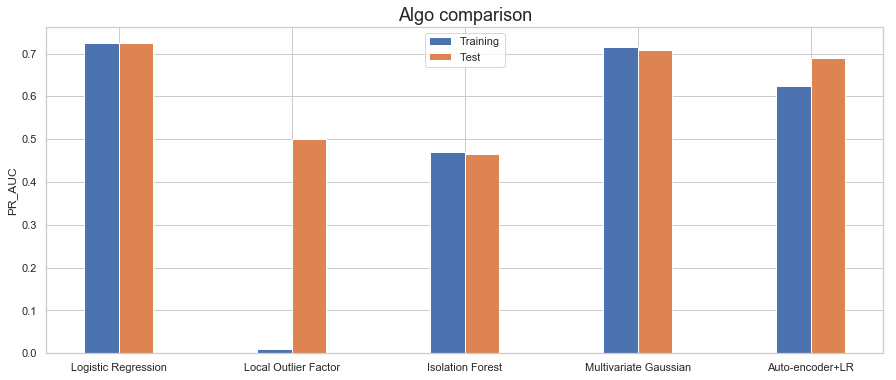

In [64]:
draw_comparison(metric='prauc', y_train=y_train, y_train_pred=train_preds, y_test=y_test, y_test_pred=test_preds)

By comparing the results of different algorithms, we may find that our baseline model, supervised learning using Logistic Regression, performs quite well. For unsupervised learning, Local Outlier Factor and Isolation Forest are kind of disappointing in this problem, besides, they are slower than other methods. SVM is even slower, in fact, it's too slow to give a result. Multivariate Gaussian seems a good method, which performs nearly as good as our baseline (supervised learning). Also, we have tried semi-supervised learning, combining Auto-encoder and Logistic Regression, and that works with a result not bad.

## 3.2 Metric without label <a id="3.2metric-without-label"></a>

In [65]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv', names=['Class'])
y_test = pd.read_csv('data/y_test.csv', names=['Class'])

X_train.drop(['Time', 'Amount'], axis=1, inplace=True)
X_test.drop(['Time', 'Amount'], axis=1, inplace=True)

### 3.2.1 Calinski-Harabaz score <a id="3.2.1calinski-harabaz-score"></a>

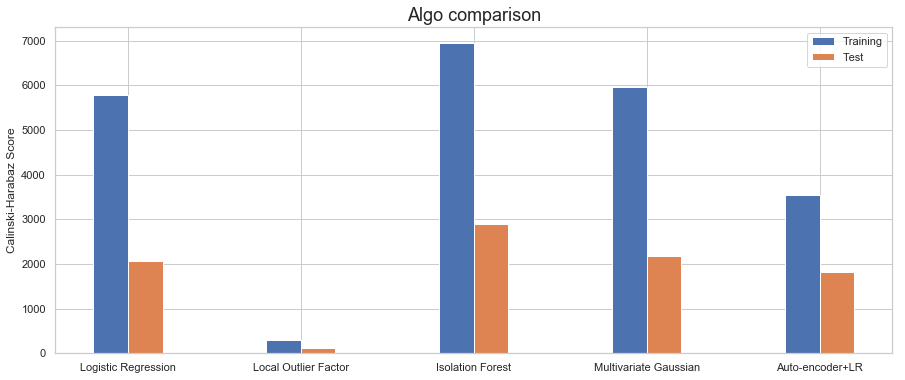

In [66]:
draw_comparison(metric='calinski', y_train_pred=train_preds, y_test_pred=test_preds, X_train=X_train, X_test=X_test)

Calinski-Harabaz score is a metric existing. Calinski-Harabaz score is also known as the Variance Ratio Criterion. The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.

However, by comparing the result above with F1 score or PR-AUC. We may say that the existing metric is not suitable for this kind of problem and dataset which is extremely imbalanced with unclear distribution. As you have said in class, there is no perpect metric for clustering (without label). It's really hard to find a new metric without label that works well.

### 3.2.2 Inovation: new metric without label <a id="3.2.2bolong-score"></a>

In [67]:
def bolong_score(X, y, normal_val=0, fraud_val=1, distance='Euc'):
    if type(y) is np.ndarray:
        y = pd.DataFrame(y, columns=['Class'])
    df = pd.concat([X, y], axis=1)
    normal = df[df.iloc[:,-1]==normal_val].iloc[:,:-1].values
    fraud = df[df.iloc[:,-1]==fraud_val].iloc[:,:-1].values
#     print('normal:',avg_distance(normal, distance))
#     print('fraud:',avg_distance(fraud, distance))
    return avg_distance(fraud, distance)/avg_distance(normal, distance)

def avg_distance(points, distance='Euc'):
    lenth, dist = len(points), 0
    center = np.mean(points, axis=0)

    if distance == 'Euc':
        for i in range(lenth):
            dist += np.linalg.norm(points[i] - center)
    elif distance == 'Man':
        for i in range(lenth):
            dist += np.linalg.norm(points[i] - center, ord=1)
    elif distance == 'Che':
        for i in range(lenth):
            dist += np.linalg.norm(points[i] - center, ord=np.inf)
    elif distance == 'Cos':
        for i in range(lenth):
            dist += np.dot(points[i],center)/(np.linalg.norm(points[i])*(np.linalg.norm(center)))
    else:
        print('unknown parameter for distance')
        return
    return dist/lenth

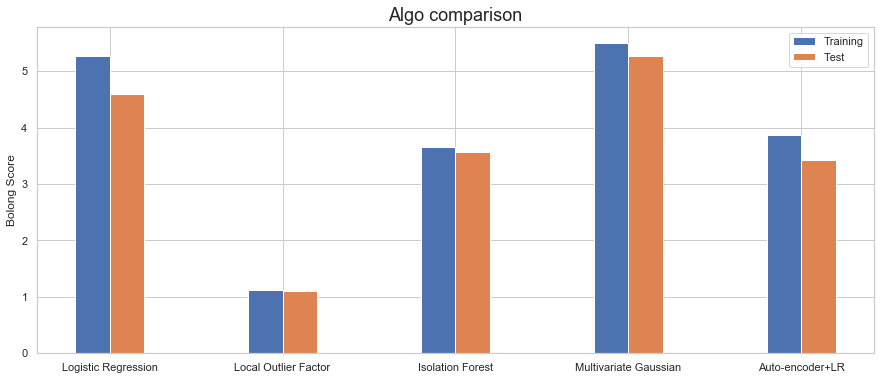

In [68]:
draw_comparison(metric='bolong', y_train_pred=train_preds, y_test_pred=test_preds, X_train=X_train, X_test=X_test)

Our new metric, Bolong Score, is specially designed for fraud detection with unsupervised learning, which means this metric doesn't need any label, the higher the score is, the better clustering is. By comparing the evaluations, our new metric is obviously better than existing metric, Calinski-Harabaz score. As you may have found, performance of Bolong Score is closer to the evaluation results of F1 score and PR-AUC. We could get the nearly the same conclusion for algorithm performance that Logistic Regression and Multivariate Gaussian works quite well, and Local Outlier Factor is not suitable for this problem.